# Overview
The purpose of this notebook is to preprocess the data, build predictive models and evaluate their results.

## Results
MAE For Each model, after hyperparamter optimization:

    -Predicting 2016's Values: 0.8746
    -Ridge Regression, Each County: 0.98531
    -Ridge Regression All Counties: 0.80919
    -Neural Net All Counties: 0.8560


# Code Navigation
* [1. Load Packages & Data](#1.LoadPackages&Data)
* [2. Preprocessing](#2.Preprocessing)
    * [2.1. Drop columns, encode cateogrical variables](#2.1.Dropcolumns,encodecateogricalvariables)
    * [2.2. Add previous years data (x3)](#2.2.Addpreviousyearsdata(x3))
    * [2.3. Inspect Distributions](#2.3.InspectDistributions)
    * [2.4. Test/Train Splits](#2.4.Test/TrainSplits)
    * [2.5. Apply Log Transform](#2.5.ApplyLogTransform)
    * [2.6. Apply Min/Max Scaling](#2.6.ApplyMin/MaxScaling)
* [3. Modeling](#3.Modeling)
    * [3.1. Predicting 2016's Values](#3.1.Predicting2016'sValues)
    * [3.2. Ridge Regression For Each County](#3.2.RidgeRegressionForEachCounty)
    * [3.3. Ridge Regression All Counties](#3.3.RidgeRegressionAllCounties)
    * [3.4. Neural Net All Counties ](#3.4.NeuralNetAllCounties)

## 1. Load Packages & Data <a class="anchor" id="1.LoadPackages&Data"></a>

In [1]:
import requests
import pandas as pd
import csv
import os
import sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from tqdm import tqdm

#Set Seaborn Styles
sns.set_style("darkgrid")
sns.set(font_scale=1.75)
 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

#Change directory to project root directory
os.chdir("..")

#Import custom code
from src.code_flow.CreateJupyterNotebookHeadings import jupyternotebookheadings1, jupyternotebookheadings2

In [2]:
df=pd.read_csv('data/interim/post_eda_diabetes_ACS_populous_counties_2004to2019.csv',index_col=0)

In [3]:
#Import sklearn
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
#Import tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 2. Preprocessing <a class="anchor" id="2.Preprocessing"></a>

## 2.1. Drop columns, encode cateogrical variables <a class="anchor" id="2.1.Dropcolumns,encodecateogricalvariables"></a>

In [4]:
#Combine state & county fips
df.state_fips=df.state_fips.astype('int')
df.county_fips=df.county_fips.astype('int')
df['state_county_fips']=df.state_fips.astype('str')+' '+df.county_fips.astype('str')
#Save a dataframe with just state/county names and fips
df_names=df[['state','county','state_fips','county_fips','state_county_fips']]
#Drop columns not to be included in the model 
col=['state','county','state_fips','county_fips','diabetes_%_lower', 'diabetes_%_upper','male']
df.drop(columns=col,inplace=True)
#Encode Region variable
df=pd.get_dummies(df,drop_first=True,columns=['region'])
#Check variables types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11296 entries, 12 to 40269
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_pop           11296 non-null  float64
 1   female              11296 non-null  float64
 2   white_pop           11296 non-null  float64
 3   black_pop           11296 non-null  float64
 4   amer_indian_pop     11296 non-null  float64
 5   pacific_island_pop  11296 non-null  float64
 6   asian_pop           11296 non-null  float64
 7   hispanic_pop        11296 non-null  float64
 8   other_pop           11296 non-null  float64
 9   20_24_years         11296 non-null  float64
 10  25_34_years         11296 non-null  float64
 11  35_44_years         11296 non-null  float64
 12  45_54_years         11296 non-null  float64
 13  55_64_years         11296 non-null  float64
 14  65_74_years         11296 non-null  float64
 15  75_84_years         11296 non-null  float64
 16  85_

## 2.2. Add previous years data (x3) <a class="anchor" id="2.2.Addpreviousyearsdata(x3)"></a>

In [5]:
df_test=df[['state_county_fips','years_since_2006','diabetes_%']]
df_test['one_year_past']=df['years_since_2006']+1
df_test['two_years_past']=df['years_since_2006']+2
df_test['three_years_past']=df['years_since_2006']+3
df_test=df_test.drop(columns=['years_since_2006']).rename(columns={'diabetes_%':'diabetes_past'})

In [6]:
a=['two_years_past','three_years_past']
b=['one_year_past','three_years_past']
c=['one_year_past','two_years_past']
df=df.merge(df_test.drop(columns=a),how='left',left_on=['years_since_2006','state_county_fips'],
            right_on=['one_year_past','state_county_fips']).drop(
            columns=['one_year_past']).rename(columns={'diabetes_past':'diabetes_1_year_past'})
df=df.merge(df_test.drop(columns=b),how='left',left_on=['years_since_2006','state_county_fips'],
            right_on=['two_years_past','state_county_fips']).drop(
            columns=['two_years_past']).rename(columns={'diabetes_past':'diabetes_2_years_past'})
df=df.merge(df_test.drop(columns=c),how='left',left_on=['years_since_2006','state_county_fips'],
            right_on=['three_years_past','state_county_fips']).drop(
            columns=['three_years_past']).rename(columns={'diabetes_past':'diabetes_3_years_past'})

In [7]:
df.head(50)

,total_pop,female,white_pop,black_pop,amer_indian_pop,pacific_island_pop,asian_pop,hispanic_pop,other_pop,20_24_years,25_34_years,35_44_years,45_54_years,55_64_years,65_74_years,75_84_years,85_plus_years,median_income,education_bach,education_hs,diabetes_%,state_county_fips,years_since_2006,region_Northeast,region_South,region_West,diabetes_1_year_past,diabetes_2_years_past,diabetes_3_years_past
0,169162.0,50.75,87.63,10.15,1.16,0.0,0.56,2.47,1.97,6.65,13.20,13.94,14.19,11.71,8.35,6.28,1.32,44878.0,25.8,86.7,7.8,1 3,0.0,0,1,0,NaN,NaN,NaN
1,171769.0,51.00,87.43,10.48,0.92,0.0,0.35,2.69,1.46,5.56,13.37,13.40,14.03,11.31,8.51,6.09,1.81,49119.0,26.4,88.3,8.1,1 3,1.0,0,1,0,7.8,NaN,NaN
2,174439.0,50.72,87.42,10.08,1.78,0.0,0.90,2.88,1.51,4.95,14.46,13.43,13.49,11.35,8.61,6.29,1.62,52320.0,29.5,87.9,8.6,1 3,2.0,0,1,0,8.1,7.8,NaN
3,179878.0,51.15,86.89,10.19,0.97,0.0,0.82,3.31,1.98,5.37,12.61,12.88,14.33,12.52,9.66,5.37,2.04,48487.0,26.5,89.2,9.9,1 3,3.0,0,1,0,8.6,8.1,7.8
4,183195.0,50.91,88.50,9.86,1.29,0.0,0.95,4.41,0.99,4.60,11.77,12.89,14.89,13.57,9.99,5.01,1.73,47502.0,27.2,87.7,10.2,1 3,4.0,0,1,0,9.9,8.6,8.1
5,186717.0,51.74,88.03,10.08,1.27,0.0,0.96,4.53,0.92,4.86,12.53,12.66,14.38,13.76,9.84,5.13,1.98,50900.0,28.3,90.4,9.8,1 3,5.0,0,1,0,10.2,9.9,8.6
6,190790.0,50.95,88.70,10.19,1.29,0.0,1.21,4.58,1.22,5.77,11.87,11.82,14.87,13.65,10.65,5.32,1.77,48378.0,29.1,89.2,9.1,1 3,6.0,0,1,0,9.8,10.2,9.9
7,195540.0,51.47,87.64,10.91,0.31,0.0,1.12,4.58,1.17,6.31,11.80,12.33,12.99,13.98,10.74,5.05,2.17,44874.0,29.0,90.6,8.8,1 3,7.0,0,1,0,9.1,9.8,10.2
8,200111.0,50.89,87.61,10.03,1.48,0.0,1.19,4.56,1.61,4.90,11.73,12.32,13.47,13.86,11.19,5.79,1.90,48461.0,30.5,89.0,9.3,1 3,8.0,0,1,0,8.8,9.1,9.8
9,203709.0,50.80,86.83,11.45,1.39,0.0,0.29,4.55,1.10,5.07,11.65,12.48,13.41,13.39,12.15,5.17,2.30,52003.0,29.5,90.8,9.3,1 3,9.0,0,1,0,9.3,8.8,9.1


In [8]:
#Remove years 2004, 2005 and 2006 to prevent any NaNs in the 'previous year's value' column
df=df[df.years_since_2006>2]

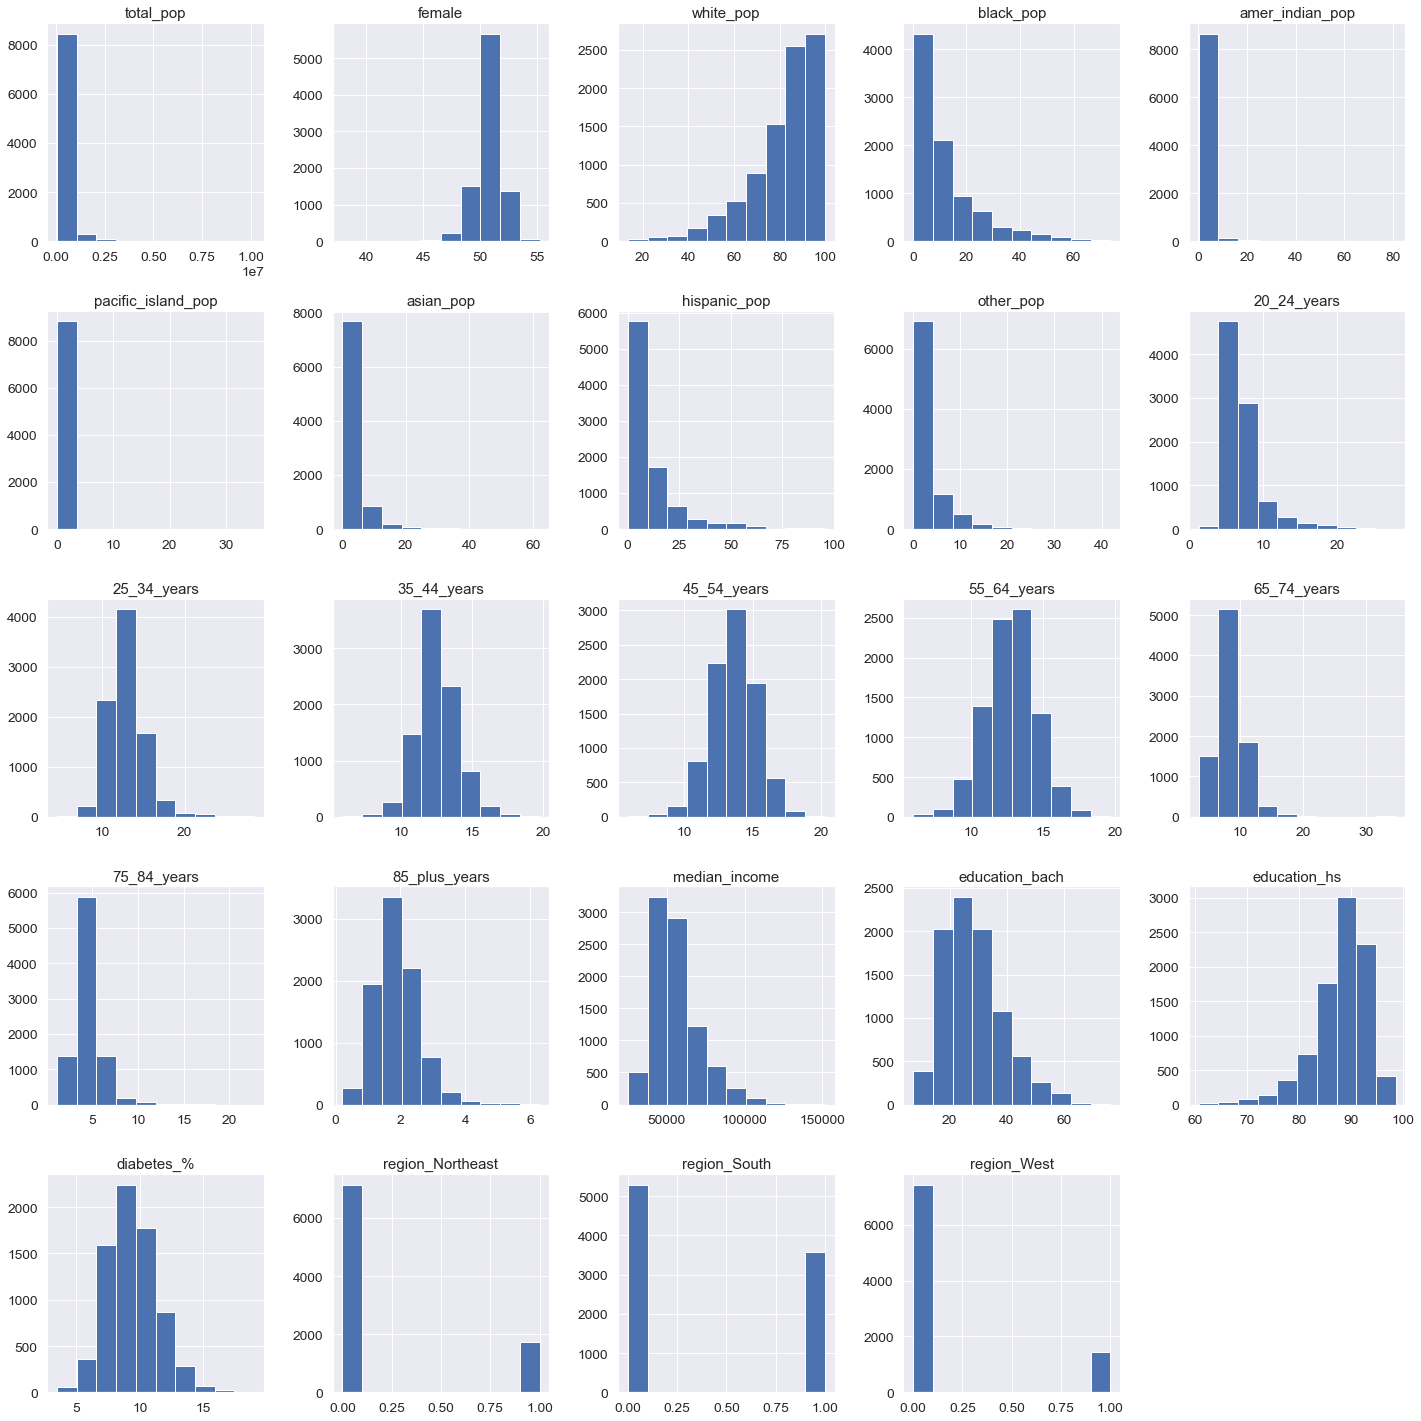

In [9]:
sns.set(font_scale=1.25)
col=['years_since_2006','diabetes_1_year_past','diabetes_2_years_past','diabetes_3_years_past']
df.drop(columns=col).hist(figsize=(20,20))
plt.tight_layout()
plt.show()

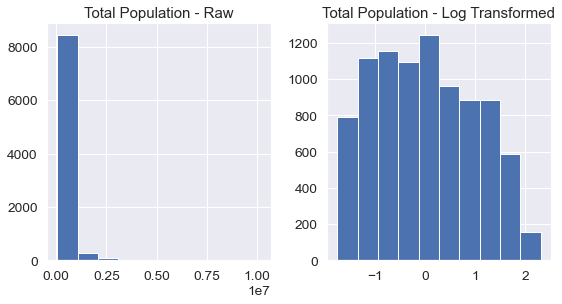

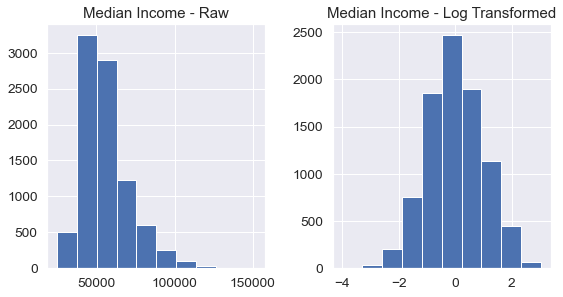

In [10]:
pt=PowerTransformer(method='box-cox')
q=np.array(df.total_pop).reshape(-1,1)
w=pt.fit_transform(q)

plt.subplots(figsize=(8,8))
plt.subplot(2,2,1)
plt.hist(q)
plt.title('Total Population - Raw')
plt.subplot(2,2,2)
plt.hist(w)
plt.title('Total Population - Log Transformed')
plt.tight_layout()

pt=PowerTransformer(method='box-cox')
q=np.array(df.median_income).reshape(-1,1)
w=pt.fit_transform(q)

plt.subplots(figsize=(8,8))
plt.subplot(2,2,3)
plt.hist(q)
plt.title('Median Income - Raw')
plt.subplot(2,2,4)
plt.hist(w)
plt.title('Median Income - Log Transformed')
plt.tight_layout()

plt.show()

## 2.4. Test/Train Splits <a class="anchor" id="2.4.Test/TrainSplits"></a>


In [11]:
df_2006_2016=df[df.years_since_2006<11].reset_index(drop=True)
df_2017=df[df.years_since_2006==11].reset_index(drop=True)
df_2018_2019=df[df.years_since_2006>11].reset_index(drop=True).drop(columns=['diabetes_%'])

## 2.5. Apply Log Transform <a class="anchor" id="2.5.ApplyLogTransform"></a>

In [12]:
def log_transform(variable):
    pt=PowerTransformer(method='box-cox')
    q=np.array(df_2006_2016[variable]).reshape(-1,1)
    w=pt.fit_transform(q)
    df_2006_2016.loc[:,variable]=w
    df_2017.loc[:,variable]=pt.transform(np.array(df_2017[variable]).reshape(-1,1))
    df_2018_2019.loc[:,variable]=pt.transform(np.array(df_2018_2019[variable]).reshape(-1,1))

In [13]:
log_transform('total_pop')
log_transform('median_income')

## 2.6. Apply Min/Max Scaling <a class="anchor" id="2.6.ApplyMin/MaxScaling"></a>

In [14]:
mm=MinMaxScaler()
#Drop state/county fips columns b/c they are strings, as well as the diabetes % because it is the vairable to be predicted
scf_2016=df_2006_2016[['state_county_fips','diabetes_%']]
df_2006_2016.drop(columns=['state_county_fips','diabetes_%'],inplace=True)
scf_2017=df_2017[['state_county_fips','diabetes_%']]
df_2017.drop(columns=['state_county_fips','diabetes_%'],inplace=True)
#Get the column names from the dataframes
df_col=df_2006_2016.columns
#Apply fit/transform to the data 
df_2006_2016=mm.fit_transform(df_2006_2016)
df_2017=mm.transform(df_2017)
#Make the data back into a dataframe
df_2006_2016=pd.DataFrame(df_2006_2016,columns=df_col)
df_2017=pd.DataFrame(df_2017,columns=df_col)
#Add back the state/county fips columns 
df_2006_2016=pd.concat([df_2006_2016,scf_2016],axis=1)
df_2017=pd.concat([df_2017,scf_2017],axis=1)

In [15]:
#Show ranges of final variables
df_2006_2016.describe().T

,count,mean,std,min,25%,50%,75%,max
total_pop,6456.0,0.432727,0.246103,0.0,0.226270,0.418676,0.628598,1.0
female,6456.0,0.743086,0.069104,0.0,0.710572,0.749278,0.785095,1.0
white_pop,6456.0,0.788715,0.169535,0.0,0.711171,0.836127,0.916803,1.0
black_pop,6456.0,0.164185,0.172877,0.0,0.043376,0.102451,0.219223,1.0
amer_indian_pop,6456.0,0.022898,0.062808,0.0,0.007064,0.010849,0.019049,1.0
pacific_island_pop,6456.0,0.011800,0.055581,0.0,0.000000,0.004850,0.010842,1.0
asian_pop,6456.0,0.057982,0.083529,0.0,0.018867,0.034745,0.066136,1.0
hispanic_pop,6456.0,0.114259,0.136823,0.0,0.034833,0.064121,0.133891,1.0
other_pop,6456.0,0.077979,0.100343,0.0,0.021104,0.042209,0.091534,1.0
20_24_years,6456.0,0.227720,0.103010,0.0,0.171246,0.199473,0.240120,1.0


## 3. Modeling <a class="anchor" id="3.Modeling"></a>

## 3.1. Predicting 2016's Values <a class="anchor" id="3.1.Predicting2016'sValues"></a>

In [16]:
def MAE(df):
    return(np.mean(np.abs(df.diabetes_pred-df.diabetes_actual_2017)))

In [17]:
#Deterime mean absolute difference between predicting 2016's value for 2017
#Select 2016 diabetes/state county fips data
df_pred=df_2006_2016[df_2006_2016.years_since_2006==df_2006_2016.years_since_2006.max()]
    [['state_county_fips','diabetes_%']].rename(columns={'diabetes_%':'diabetes_pred'})
#Select 2017 diabetes/state county fips data
df_actual=df_2017[['state_county_fips','diabetes_%']].rename(columns={'diabetes_%':'diabetes_actual_2017'})
#Concatenate the two and calculate the mean absolute error
df_pred_actual=df_pred.merge(df_actual,how='inner',right_on='state_county_fips',left_on='state_county_fips')
print('Using 2016 values as a prediction for 2017 results in an MAE of',round(MAE(df_pred_actual),5))

Using 2016 values as a prediction for 2017 results in an MAE of 0.8746


## 3.2. Ridge Regression For Each County <a class="anchor" id="3.2.RidgeRegressionForEachCounty"></a>

In [18]:
df_X=df_2006_2016.drop(columns=['diabetes_%'])
df_y=df_2006_2016[['diabetes_%','state_county_fips']]
county_list=list(df_X.state_county_fips.unique())

results={}
i=[round((0.01*j)*5,2) for j in range (1,20)]
for alpha in i:
    models_dict={}
    for county in county_list:
        X=df_X[df_X.state_county_fips==county].drop(columns=['state_county_fips'])
        y=df_y[df_y.state_county_fips==county].drop(columns=['state_county_fips'])
        clf=Ridge(alpha=alpha)
        clf.fit(X,y)
        models_dict[county]=clf

    pred_2017_dict={}
    for key, value in models_dict.items():
        df_=df_2017[df_2017.state_county_fips==key].drop(columns=['diabetes_%','state_county_fips'])
        val=float(value.predict(df_)[0])
        pred_2017_dict[key]=val

    pred_2017_df=pd.DataFrame.from_dict(pred_2017_dict,orient='index').reset_index().rename(columns={0:'diabetes_pred'})
    pred_LR=pred_2017_df.merge(df_actual,how='inner',right_on='state_county_fips',left_on='index')
    mae=MAE(pred_LR)
    results[alpha]=mae

alpha_best=min(results,key=results.get)
mae_best=results[alpha_best]
print('Multiple individual Ridge regression models results in a best MAE of {}. The alpha value used was {}'.format(round(float(mae_best),5),alpha_best))

Multiple individual Ridge regression models results in a best MAE of 0.93391. The alpha value used was 0.05


## 3.3. Ridge Regression All Counties <a class="anchor" id="3.3.RidgeRegressionAllCounties"></a>

### Ridge Regression

In [87]:
X_train=df_2006_2016.drop(columns=['diabetes_%','state_county_fips'])
y_train=df_2006_2016[['diabetes_%']]
X_test=df_2017.drop(columns=['diabetes_%','state_county_fips'])
y_test=df_2017[['diabetes_%']]

i=[1]+[1/(10**j) for j in range (1,8)]
results={}

for alpha in i:
    clf=Ridge(alpha=alpha)
    clf.fit(X_train,y_train)
    pred=pd.DataFrame(clf.predict(X_test))
    df_temp=pd.concat([pred,y_test],axis=1).rename(columns={0:'diabetes_pred','diabetes_%':'diabetes_actual_2017'})
    results[alpha]=MAE(df_temp)

alpha_best=min(results,key=results.get)

In [90]:
#Create Model based on best alpha 
clf=Ridge(alpha=alpha_best)
clf.fit(X_train,y_train)
pred=pd.DataFrame(clf.predict(X_test))
df_temp=pd.concat([pred,y_test],axis=1).rename(columns={0:'diabetes_pred','diabetes_%':'diabetes_actual_2017'})
results[alpha]=MAE(df_temp)

In [97]:
clf.coef_

[array([-0.06309502]),
 array([0.14230916]),
 array([-0.06355436]),
 array([0.4730308]),
 array([0.58679224]),
 array([-0.30252077]),
 array([0.46609204]),
 array([-0.80006259]),
 array([0.1697248]),
 array([-0.21777997]),
 array([-0.09077781]),
 array([0.49618822]),
 array([-0.26439159]),
 array([-0.28567827]),
 array([-0.28955947]),
 array([0.17284059]),
 array([-0.23285429]),
 array([-0.56932585]),
 array([-1.47286093]),
 array([-0.30581109]),
 array([0.29098226]),
 array([0.042434]),
 array([0.09181667]),
 array([-0.18370599]),
 array([10.44363018]),
 array([0.76424972]),
 array([-1.44270653])]

In [94]:
#Coefficient Importance - Note they are sorted by ABSOLUTE value.
clf_coef=pd.DataFrame([X_train.columns,clf.coef_.T]).T.rename(columns={0:'Feature',1:'Coefficient'})
clf_coef.reindex(clf_coef.Coefficient.abs().sort_values(ascending=False).index)

,Feature,Coefficient
24,diabetes_1_year_past,[10.443630183838758]
18,education_bach,[-1.4728609309083205]
26,diabetes_3_years_past,[-1.442706527211977]
7,hispanic_pop,[-0.8000625943989478]
25,diabetes_2_years_past,[0.7642497231907368]
4,amer_indian_pop,[0.5867922428758999]
17,median_income,[-0.5693258544356934]
11,35_44_years,[0.49618821682809494]
3,black_pop,[0.4730308007553674]
6,asian_pop,[0.466092039804926]


In [92]:
mae_best=results[alpha_best]
print('A single Ridge regression model results in a best MAE of {}. The alpha value used was {}'.format(round(float(mae_best),5),alpha_best))

A single Ridge regression model results in a best MAE of 0.80179. The alpha value used was 1


## 3.4. Neural Net All Counties  <a class="anchor" id="3.4.NeuralNetAllCounties"></a>

In [ ]:
X_train=df_2006_2016.drop(columns=['diabetes_%','state_county_fips'])
y_train=df_2006_2016[['diabetes_%']]
X_test=df_2017.drop(columns=['diabetes_%','state_county_fips'])
y_test=df_2017[['diabetes_%']]

In [ ]:
#Code adapted from https://www.youtube.com/watch?v=-vHQub0NXI4, accessed 7/9/2021
def build_model():
    model=keras.Sequential([
        layers.Dense(100,activation=tf.nn.relu, input_shape=[len(X_train.columns)]),
        layers.Dense(100,activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer= tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

In [ ]:
model=build_model()
model.summary()

In [ ]:
class PrintDot (keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%100==0: print('')
        print('.',end='')
    
#Prevent Overfitting
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

EPOCHS=100

history=model.fit(
    X_train, y_train,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[early_stop, PrintDot()])

In [ ]:
loss, mae, mse = model.evaluate(X_test,y_test,verbose=0)
print('A single neural net model results an MAE of {}.'.format(mae))